In [16]:
import time


import pandas as pd
import numpy as np
import os
from brick import Brick
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt


### Working on extracting the first systematic from the dataset -  stellar Density

Data use: We create a catalog of stars from DECaLS by selecting objects lying in the stellar locus (using the color cut 17 < r < 18) with PSF morphology.

Information on a per brick basis

In [17]:
hdulistBricksSouthSummary = fits.open('../bricks_data/survey-bricks-dr9-south.fits')
data_south = hdulistBricksSouthSummary[1].data
brickname_south = data_south.field('brickname')
brickid_south = data_south.field('brickid')
south_survey_is_south = data_south.field('survey_primary')

hdulistBricksNorthSummary = fits.open('../bricks_data/survey-bricks-dr9-north.fits')
data_north = hdulistBricksNorthSummary[1].data
brickname_north = data_north.field('brickname')
brickid_north = data_north.field('brickid')
survey_north = data_north.field('survey_primary')
north_survey_is_south = np.invert(survey_north)

In [26]:
print()
print("=============================== Classification Stellar Density... ==================================")
print()

start = time.time()

bricknames_south_sample = []

for filename in os.listdir('/Volumes/Astrostick/bricks_data/south/'):
    brickn = filename.replace("tractor-", "")
    brickn = brickn.replace(".fits", "")
    bricknames_south_sample.append(brickn)

bricknames_south_sample.pop()

def get_stellar_objects(self, mag_r):

        is_PSF =  (self.type == 'PSF') & (mag_r > 17) & (mag_r < 18)
        return is_PSF

df = pd.DataFrame(columns=['RA', 'DEC', 'GMAG', 'RMAG', 'ZMAG', 'GMR', 'RMZ'])

for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data
    ra = data.field('ra')
    dec = data.field('dec')
    brick = Brick(data)
    brick.initialise_brick_for_stellar_density()


    mag_g = 22.5-2.5*np.log10(brick.flux_g.clip(1e-7))
    mag_r = 22.5-2.5*np.log10(brick.flux_r.clip(1e-7))
    mag_z = 22.5-2.5*np.log10(brick.flux_z.clip(1e-7))


    stars = get_stellar_objects(brick, mag_r)
    gmr = mag_g-mag_r
    rmz = mag_r-mag_z

    stacked_array = np.stack(( ra, dec, mag_g, mag_r, mag_z, gmr, rmz), axis=1)
    stacked_array = stacked_array[np.where(stars == True)]

    support_df = pd.DataFrame(stacked_array, columns=['RA', 'DEC', 'GMAG', 'RMAG', 'ZMAG', 'GMR', 'RMZ'])
    df = df.append(support_df)

    if no % 50 == 0:
        print(stars.sum())
        print(no)
print(df.head())
df.describe()
df = df.drop_duplicates()
df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)



=============================== Classification Stellar Density... ==================================

35
0
25
50
29
100
41
150
32
200
29
250
68
300
15
350
14
400
17
450
148
500
0
550
31
600
26
650
44
700
105
750
16
800
23
850
12
900
71
950
29
1000
25
1050
           RA        DEC       GMAG       RMAG       ZMAG       GMR       RMZ
0  244.255339  25.636063  17.763409  17.504335  17.407810  0.259073  0.096525
1  244.261321  25.823997  18.458643  17.773663  17.464451  0.684980  0.309212
2  244.265387  25.652155  18.473047  17.890720  17.608532  0.582327  0.282188
3  244.268755  25.820972  18.785490  17.418488  16.571255  1.367002  0.847233
4  244.276164  25.681149  19.206987  17.825157  16.862991  1.381830  0.962166


In [27]:
#df = pd.read_csv('../bricks_data/galaxy_catalogue_stellar.csv')
df.describe()


,RA,DEC,GMAG,RMAG,ZMAG,GMR,RMZ
count,40062.000000,40062.000000,40062.000000,40062.000000,40062.000000,40062.000000,40062.000000
mean,198.130213,-2.551337,18.606974,17.529005,17.245522,1.077968,0.283483
std,111.749877,27.129711,2.226397,0.287525,2.370249,2.202023,2.357666
min,0.000972,-67.849736,10.821396,17.000078,13.237497,-6.659172,-22.996998
25%,92.698351,-16.198971,18.003589,17.285598,16.752713,0.526308,0.197934
50%,224.227322,4.837216,18.367132,17.544015,17.080685,0.759930,0.340376
75%,309.484436,18.624135,18.767715,17.780163,17.399005,1.264541,0.696470
max,359.993021,35.350494,40.000000,17.999968,40.000000,22.992443,4.601538


In [41]:
# REMOVING OUTLIERS

df = df[(df['GMAG'] > 15) & (df['GMAG'] < 30) ]
df = df[(df['ZMAG'] > 15) & (df['ZMAG'] < 30) ]
df = df[(df['GMR'] > -2) & (df['GMR'] < 4) ]
df = df[(df['RMZ'] > -2) & (df['RMZ'] < 4) ]


df.describe()

#

,RA,DEC,GMAG,RMAG,ZMAG,GMR,RMZ
count,39262.000000,39262.000000,39262.000000,39262.000000,39262.000000,39262.000000,39262.000000
mean,197.376717,-2.581661,18.388056,17.529305,17.011441,0.858750,0.517864
std,112.141076,26.984569,0.506863,0.287399,0.517372,0.395520,0.457271
min,0.000972,-67.849736,15.099892,17.000078,15.014045,-1.930622,-1.981371
25%,90.031631,-15.476316,17.999770,17.286364,16.748784,0.524787,0.201121
50%,221.313647,4.796337,18.359766,17.544312,17.074396,0.753615,0.344564
75%,309.555707,18.471978,18.751563,17.780488,17.387320,1.246618,0.702454
max,359.993021,35.350494,21.034042,17.999968,19.885351,3.619890,2.696612


(array([4.0000e+00, 4.0000e+00, 3.2000e+01, 6.0100e+02, 2.1370e+04,
        1.1444e+04, 5.7800e+03, 2.0000e+01, 4.0000e+00, 3.0000e+00]),
 array([-1.9306221 , -1.37557087, -0.82051964, -0.26546841,  0.28958282,
         0.84463406,  1.39968529,  1.95473652,  2.50978775,  3.06483898,
         3.61989021]),
 <BarContainer object of 10 artists>)

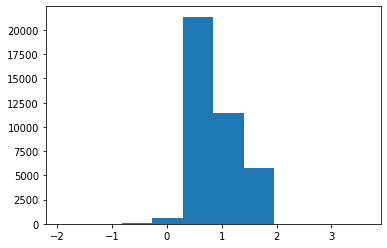

In [42]:
plt.hist(df['GMR'])

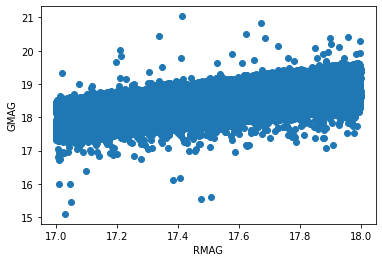

In [46]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.scatter(df[label_1], df[label_2])
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.show()

In [ ]:
for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south_test/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data
    ra = data.field('ra')
    dec = data.field('dec')
    brick = Brick(data)
    brick.initialise_brick_for_stellar_density()
    fluxr = brick.get_stellar_objects()
    print(len(fluxr))
    plt.hist(fluxr, range=(0,30))
    plt.show()
    

    if no == 0:
        break

In [24]:
print("Wrong Cell")
exit()

print()
print("=============================== Classification Stellar Density... ==================================")
print()

start = time.time()

bricknames_south_sample = []

for filename in os.listdir('/Volumes/Astrostick/bricks_data/south/'):
    brickn = filename.replace("tractor-", "")
    brickn = brickn.replace(".fits", "")
    bricknames_south_sample.append(brickn)

#bricknames_south_sample.pop()
df = pd.DataFrame(columns=['RA', 'DEC'])

for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data

    brick = Brick(data)
    ra = data.field('ra')
    dec = data.field('dec')

    brick.initialise_brick_for_stellar_density()

    # Extracting Positions, and Object IDs

    stellar_density = brick.get_stellar_objects()

    # Process array
    stacked_array = np.stack(( ra, dec, stellar_density), axis=1)
    support_df = pd.DataFrame(stacked_array, columns=['RA', 'DEC', 'Target_type'])
    support_df.drop(support_df[support_df.Target_type == 0].index, inplace=True)
    support_df.drop(columns='Target_type')
    df = df.append(support_df)

print()
print("=============================== Classification Stellar Completed ==================================")
print()
df = df[df['Target_type'] > 0]
df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)
print(df.shape)
print(df.head())

print("Time taken for ", len(bricknames_south_sample), " bricks: ", time.time() - start)


=============================== Classification Stellar Density... ==================================



ValueError: all input arrays must have the same shape

In [ ]:
df = pd.read_csv('../bricks_data/galaxy_catalogue_stellar.csv')

duplicates_removed = df.drop_duplicates()

duplicates_removed.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)


# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

In [ ]:
def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

In [ ]:
ra = df["RA"].to_numpy(copy=True)
dec = df["DEC"].to_numpy(copy=True)

theta, phi = raDec2thetaPhi(ra, dec)

print("Number of stellar objects in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of Stars in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

mean = counts.mean()
print("Mean stellar objects per Pixel:", mean)
# Calculating Densities for every block
density = (counts / mean) - 1

m[unique] = density
hp.mollview(m, title="Stellar Density", norm="hist",cmap="jet")
hp.graticule()